In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dset-pequenio/DiccionarioDatos_2023.ods
/kaggle/input/dset-peq/dataset_pequeno.csv
/kaggle/input/laboratorio-de-imp-i-2023-virtual/kaggle_competencia_muestra.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import os


from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from featurewiz import featurewiz
from imblearn.under_sampling import RandomUnderSampler
from scipy import sparse


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# Read the dataset
dataset = pd.read_csv('/kaggle/input/dset-peq/dataset_pequeno.csv')

dtrain = dataset[dataset['foto_mes'] == 202107].copy()
dapply = dataset[dataset['foto_mes'] == 202109].drop('clase_ternaria', axis=1)

dtrain['clase_ternaria'].replace({'BAJA+2': 2, 'BAJA+1':1, 'CONTINUA':0}, inplace=True)

Imported 0.2.6 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



# EDA

In [3]:
dapply.shape, dtrain.shape

((165237, 154), (164682, 155))

In [4]:
def preproc_func(dtrain, agrup):
    '''elimina nulos, joinea columnas con conceptos similares'''

    def find_cols_with_high_nan(df, threshold=0.80): 
        nan_pct = df.isna().sum() / len(df)    
        # Select columns with NaN percentage greater than the threshold
        high_nan_cols = nan_pct[nan_pct > threshold].index.tolist()    
        return high_nan_cols

    def join_cols(df, string):
        joined_cols = df.filter(like=string)
        df[string] = joined_cols.sum(axis=1)
        return dtrain.drop(columns=joined_cols.columns)

    # Get the Visa and Master columns lists
    visa_columns = dtrain.filter(like='Visa_').columns.to_list()
    master_columns = dtrain.filter(like='Master_').columns.to_list()

    # Iterate through the corresponding columns and create the new columns in the DataFrame
    for col_visa, col_master in zip(visa_columns, master_columns):
        new_column_name = 'sum_' + col_visa.split('_', 1)[1]  # Remove the 'Visa_' prefix and add 'sum_' prefix
        dtrain[new_column_name] = dtrain[col_visa] + dtrain[col_master]

    dtrain.drop(columns=visa_columns+master_columns, inplace=True)

    for i in agrup:
        dtrain = join_cols(dtrain, i)

    cols_to_drop =['ccuenta_corriente','foto_mes'] + find_cols_with_high_nan(dtrain)
    print(f'dropping {cols_to_drop}')
    dtrain = dtrain.drop(columns=cols_to_drop)    
    return dtrain


def find_good_ratios(data):
    '''crea ratios de todas las features float y se queda con los que featurewiz le da importancia, devuelve una lista de buenos candidatos para ratio'''
    def _create_ratios(dataframe, variable,target):
        float_cols = dataframe.select_dtypes(include='float64').columns.tolist()    
        new_dataframe = pd.DataFrame()    
        for col in float_cols:
            if col != variable:
                new_col_name = f'{variable}_to_{col}'
                new_dataframe[new_col_name] = dataframe[variable] / dataframe[col]

        new_dataframe[target] = dataframe[target]
        return new_dataframe    
    
    the_best = []
    for i in data.select_dtypes(include='float64').columns.tolist():
        temp_df = _create_ratios(data, i,'clase_ternaria')
        try:
            best_ratios = featurewiz(temp_df, 'clase_ternaria')
            the_best.append(best_ratios[0])
        except:
            the_best.append(f'error with {i}')
    return the_best


def create_ratios_from_best(df, lista_best):
    '''crea las features a partir de una lista de listas que tiene los mejores ratios'''
    data = df.copy()    
    for ratios in lista_best:
        if "error" in ratios:
            print(f"Skipping invalid ratio: {ratios}")
            continue
        else:
            for j in ratios:
                variables = j.split('_to_')
                data[j] = data[variables[0]] / data[variables[1]]           
    return data


def undersample_multiclass(dataframe, target_col):
    X = dataframe.drop(target_col, axis=1)
    y = dataframe[target_col]
    rus = RandomUnderSampler()   
    X_resampled, y_resampled = rus.fit_resample(X, y)
    resampled_df = pd.concat([X_resampled, y_resampled], axis=1)
    return resampled_df

In [5]:
palabras_agrupar =['prestamo','seguro','servicios', 'comisiones','cheques','ahorro','inversion','tarjeta','_consumo','margen','debit','forex', 'transfer','autoservicio','cajas','atm','trx','mobile']

dtrain = preproc_func(dtrain,palabras_agrupar)

dropping ['ccuenta_corriente', 'foto_mes', 'sum_Finiciomora']


In [6]:
#undersamplear para ver importancia 
resampled_df = undersample_multiclass(dtrain, 'clase_ternaria')
best_unb = find_good_ratios(resampled_df)

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.8 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (3234, 46)
#### Single_Label Multi_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
##############################################

In [7]:
best_unb

[['mrentabilidad_to_ahorro',
  'mrentabilidad_to_sum_fultimo_cierre',
  'mrentabilidad_to_margen',
  'mrentabilidad_to_sum_mlimitecompra'],
 ['mrentabilidad_annual_to_ahorro',
  'mrentabilidad_annual_to_sum_fultimo_cierre'],
 'error with mcuenta_corriente_adicional',
 ['mcuenta_corriente_to_ahorro',
  'mcuenta_corriente_to_sum_mlimitecompra',
  'mcuenta_corriente_to_sum_fultimo_cierre',
  'mcuenta_corriente_to_sum_Fvencimiento',
  'mcuenta_corriente_to_mrentabilidad'],
 ['mcuentas_saldo_to_sum_fechaalta',
  'mcuentas_saldo_to_sum_fultimo_cierre',
  'mcuentas_saldo_to_ahorro'],
 ['mplazo_fijo_dolares_to_sum_mpagospesos',
  'mplazo_fijo_dolares_to_sum_mfinanciacion_limite',
  'mplazo_fijo_dolares_to_mcuentas_saldo',
  'mplazo_fijo_dolares_to_sum_fultimo_cierre',
  'mplazo_fijo_dolares_to_sum_fechaalta',
  'mplazo_fijo_dolares_to_tarjeta'],
 ['mplazo_fijo_pesos_to_transfer',
  'mplazo_fijo_pesos_to_sum_cconsumos',
  'mplazo_fijo_pesos_to_sum_mconsumototal'],
 ['mpayroll_to_sum_mlimitecomp

In [11]:
dtrain = create_ratios_from_best(dtrain, best_unb)

Skipping invalid ratio: error with mcuenta_corriente_adicional
Skipping invalid ratio: error with sum_madelantodolares
Skipping invalid ratio: error with _consumo


In [16]:
cols_keep_as_is = ['active_quarter','cliente_vip','internet','tcuentas','cdescubierto_preacordado','ccaja_seguridad','tcallcenter','thomebanking','cplazo_fijo','cajas','mobile']
cols_to_binarize = ['cliente_edad','cliente_antiguedad','cproductos','cpagomiscuentas','ccajeros_propios_descuentos','ccallcenter_transacciones','chomebanking_transacciones','seguro','trx']
cols_to_normalize = list(dtrain.select_dtypes('float').columns)

#len(cols_keep_as_is + cols_to_binarize+cols_to_normalize) == len(set(cols_keep_as_is + cols_to_binarize+cols_to_normalize))
set(dtrain.columns) - set(cols_keep_as_is + cols_to_binarize+cols_to_normalize)

{'clase_ternaria', 'numero_de_cliente'}

# pipeline preprocessing

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion    
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_is_fitted


class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]


class StandardScalerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.scaler = StandardScaler()
        
    def fit(self, X, y=None):
        cols_to_scale = self.columns or X.select_dtypes(include='number').columns
        self.scaler.fit(X[cols_to_scale])
        return self
        
    def transform(self, X):
        cols_to_scale = self.columns or X.select_dtypes(include='number').columns
        X_transformed = pd.DataFrame(self.scaler.transform(X[cols_to_scale]), columns=cols_to_scale, index=X.index)
        return pd.concat([X.drop(columns=cols_to_scale), X_transformed], axis=1)
    
    
class PandasFeatureUnion(BaseEstimator, TransformerMixin):
    def __init__(self, transformers):
        self.transformers = transformers

    def fit(self, X, y=None):
        for _, transformer in self.transformers:
            transformer.fit(X, y)
        return self

    def transform(self, X, y=None):
        transformed_dfs = []
        for _, transformer in self.transformers:
            transformed_dfs.append(transformer.transform(X))        
        
        concatenated_df = pd.concat(transformed_dfs, axis=1)
        return concatenated_df
    

class BinTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins, columns=None):
        self.n_bins = n_bins
        self.columns = columns
        
    def fit(self, X, y=None):
        self.quantiles_ = {}
        self.outliers_ = {}
        cols_to_transform = self.columns or X.select_dtypes(include=np.number).columns
        for col in cols_to_transform:          
            q1, q3 = np.percentile(X[col], [25, 75])
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            mask = (X[col] < lower_bound) | (X[col] > upper_bound)
            self.outliers_[col] = mask
            col_no_outliers = X.loc[~mask, col]
            self.quantiles_[col] = pd.qcut(col_no_outliers, self.n_bins, labels=False, duplicates='drop')
        return self

    def transform(self, X):
        check_is_fitted(self)
        X_trans = X.copy()
        cols_to_transform = self.columns or X_trans.select_dtypes(include=np.number).columns
        for col in cols_to_transform:         
            X_trans[col] = pd.cut(X_trans[col], bins=self.n_bins, labels=False, duplicates='drop')
            X_trans.loc[self.outliers_[col].reindex(X.index, fill_value=False).values, col] = 'outlier'
            if col in self.quantiles_:
                X_trans.loc[~self.outliers_[col].reindex(X.index, fill_value=False), col] = 'bin_' + self.quantiles_[col].apply(lambda x: str(x)).astype(str)      
    
        return X_trans[cols_to_transform]
    
    
class OneHotEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_cols=None):
        self.categorical_cols = categorical_cols
    
    def fit(self, X, y=None):
        if self.categorical_cols is None:
            self.categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
        
        self.categories_ = [X[col].astype('category').cat.categories.tolist() + ['dummy'] for col in self.categorical_cols]
        self.encoder = OneHotEncoder(categories=self.categories_, handle_unknown='ignore')
        self.encoder.fit(X[self.categorical_cols])
        return self
    
    def transform(self, X, y=None):
        X_transformed = self.encoder.transform(X[self.categorical_cols])
        feature_names = self.encoder.get_feature_names_out(self.categorical_cols)
        X_transformed_df = pd.DataFrame.sparse.from_spmatrix(X_transformed, columns=feature_names)
        X_transformed_df.index = X.index
        return pd.concat([X.drop(columns=self.categorical_cols), X_transformed_df], axis=1)

import category_encoders as ce
class TargetEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None, drop_invariant=False, return_df=True):
        self.cols = cols
        self.drop_invariant = drop_invariant
        self.return_df = return_df
        self.encoder = ce.TargetEncoder(cols=self.cols, drop_invariant=self.drop_invariant, return_df=self.return_df)

    def fit(self, X, y=None):
        self.encoder.fit(X, y)
        return self

    def transform(self, X, y=None):
        return self.encoder.transform(X, y)
    
    

from sklearn.impute import SimpleImputer

class SimpleImputerWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean'):
        self.strategy = strategy
        self.imputer = SimpleImputer(strategy=strategy)
    
    def fit(self, X, y=None):
        self.imputer.fit(X)
        return self
    
    def transform(self, X):
        X_transformed = self.imputer.transform(X)
        return pd.DataFrame(X_transformed, columns=X.columns, index=X.index)
    
    
class PercentageVariationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, variable):
        self.variable = variable

    def fit(self, X, y):
        # Combine X and y for easier calculations
        data = pd.concat([X, y], axis=1)

        # Calculate the mean of the variable for different target values
        self.target_means = data.groupby(y.name)[self.variable].mean()
        return self

    def transform(self, X, y=None):
        result = pd.DataFrame()

        # Calculate the percentage variation for each target mean
        for target_value, target_mean in self.target_means.items():
            column_name = f"{self.variable}_pct_variation_{target_value}"
            result[column_name] = (X[self.variable] - target_mean) / target_mean * 100

        return result

## feature engineering

In [19]:
class RatioFeature(BaseEstimator, TransformerMixin):
    def __init__(self, base_var, other_vars):
        self.base_var = base_var
        self.other_vars = other_vars if other_vars is not None else []

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Asegurarse de que el input es un DataFrame de pandas
        if not isinstance(X, pd.DataFrame):
            raise ValueError("El input debe ser un DataFrame de pandas")

        # Verificar que base_var existe en el DataFrame
        if self.base_var not in X.columns:
            raise ValueError(f"La columna '{self.base_var}' no se encuentra en el DataFrame")

        # Crear un DataFrame vacío para almacenar las nuevas features
        new_features = pd.DataFrame()

        # Calcular las nuevas features
        for var in self.other_vars:
            if var in X.columns:
                feature_name = f"{self.base_var}_{var}_ratio"
                new_features[feature_name] = X[self.base_var] / X[var]
            else:
                raise ValueError(f"La columna '{var}' no se encuentra en el DataFrame")
        return new_features
    
    
class JoinColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, like_strings):
        self.like_strings = like_strings

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Asegurarse de que el input es un DataFrame de pandas
        if not isinstance(X, pd.DataFrame):
            raise ValueError("El input debe ser un DataFrame de pandas")

        # Crear un DataFrame vacío para almacenar las nuevas columnas
        new_cols = pd.DataFrame(index=X.index)

        # Iterar sobre las cadenas especificadas
        for like_string in self.like_strings:
            # Filtrar las columnas que contienen la cadena específica
            joined_cols = X.filter(like=like_string)

            # Crear una nueva columna con la suma de las columnas filtradas
            new_col_name = 'sum_'+like_string
            new_cols[new_col_name] = joined_cols.sum(axis=1)

        return new_cols
    
from sklearn.preprocessing import StandardScaler

class StandardScalerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.scaler = StandardScaler()
        
    def fit(self, X, y=None):
        cols_to_scale = X.select_dtypes(include='number').columns if self.columns is None else self.columns
        self.scaler.fit(X[cols_to_scale])
        return self
        
    def transform(self, X):
        cols_to_scale = X.select_dtypes(include='number').columns if self.columns is None else self.columns
        X_transformed = pd.DataFrame(self.scaler.transform(X[cols_to_scale]), columns=cols_to_scale, index=X.index)
        return pd.concat([X.drop(columns=cols_to_scale), X_transformed], axis=1)
    
    
from sklearn.base import TransformerMixin, BaseEstimator
import pandas as pd
import numpy as np

from sklearn.base import TransformerMixin, BaseEstimator
import pandas as pd
import numpy as np

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class ReplaceInfTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, factor = 3):
        self.column_max_values = {}
        self.column_min_values = {}
        self.factor = factor

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input should be a pandas DataFrame")

        for column in X.columns:
            max_value = X[column].replace([np.inf, -np.inf], np.nan).max()
            min_value = X[column].replace([np.inf, -np.inf], np.nan).min()

            self.column_max_values[column] = max_value
            self.column_min_values[column] = min_value

        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input should be a pandas DataFrame")

        X_copy = X.copy()

        for column in X_copy.columns:
            if column in self.column_max_values:
                X_copy[column] = X_copy[column].replace(np.inf, self.column_max_values[column] * self.factor)
            if column in self.column_min_values:
                X_copy[column] = X_copy[column].replace(-np.inf, self.column_min_values[column] * self.factor)

        return X_copy

In [37]:
binning = Pipeline([
    ('col_select',ColumnSelector(columns=cols_to_binarize)),
    ('bin_convert',BinTransformer(columns=None, n_bins = 3)),
    ('onehot', OneHotEncoderTransformer())
    #('target_encoding', TargetEncoderWrapper()) 
])

standarize = Pipeline([
    ('col_select',ColumnSelector(columns=cols_to_normalize)),
    ('scale', StandardScalerTransformer(columns=cols_to_normalize)),
])

feature_engineering = PandasFeatureUnion([
    ('as_is', ColumnSelector(columns=cols_keep_as_is)),
    ('log', standarize),
    ('bin_convert',binning)
])

preprocessing = Pipeline([    
    ('inf', ReplaceInfTransformer()),
    ('fillna', SimpleImputerWrapper(strategy='mean')),
    ('feature_engineering', feature_engineering)
])

In [38]:
X = dtrain.drop('clase_ternaria', axis=1)
y = dtrain['clase_ternaria']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the preprocessing pipeline on the training set and transform both the training and test sets
X_train_processed = preprocessing.fit_transform(X_train, y_train)
X_test_processed = preprocessing.transform(X_test)

# Check the shapes of the processed data
print(X_train_processed.shape, X_test_processed.shape)

(115277, 274) (49405, 274)


## model evaluation

In [40]:
def get_balanced_classes():
    class_counts = y.value_counts()
    total_samples = class_counts.sum()
    class_frequencies = class_counts / total_samples
    class_weights = 1 / class_frequencies
    return class_weights.to_dict()

class_weights_dict = get_balanced_classes()

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from lightgbm import early_stopping, log_evaluation

def objective(trial):
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    f1_scores = []
    for train_index, val_index in kf.split(X_train_processed):
        X_tr, X_val = X_train_processed.iloc[train_index], X_train_processed.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        params = {
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
            "max_depth": trial.suggest_int("max_depth", 1, 10),
            "num_leaves": trial.suggest_int("num_leaves", 2, 128),  # Fix the maximum value for num_leaves
            
            'class_weight': class_weights_dict,  
#             "objective": "multiclass",
#             "metric": "multi_logloss",
#             "num_class": 3,
#             "verbosity": -1,
#             "boosting_type": "gbdt",                      
#             "n_estimators": trial.suggest_int("n_estimators", 100, 1000),          
#             "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 50),
#             "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
#             "subsample": trial.suggest_float("subsample", 0.4, 1.0),
#             "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
#             "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
#             "min_gain_to_split": trial.suggest_float("min_gain_to_split", 1e-8, 1.0)
        }

        clf = lgb.LGBMClassifier(device='gpu', **params)
        
        try:
            clf.fit(
                X_tr, y_tr, 
                eval_set=[(X_val, y_val)], 
                callbacks=[early_stopping(50), lgb.log_evaluation(period=50)]
            )    
        
        except lgb.basic.LightGBMError as e:
            print(f"Trial {trial.number} failed with parameters: {params}")
            print(f"Current best parameters: {trial.study.best_params}")
            raise e
            
        y_pred = clf.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='macro')
        f1_scores.append(f1)

    return sum(f1_scores) / len(f1_scores)


def optimize_lgbm_hyperparameters():
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    print(f"Best trial: {study.best_trial.params}")
    print(f"Best F1 score: {study.best_value}")
    return study.best_trial.params

best_params = optimize_lgbm_hyperparameters()

[LightGBM] [Warning] lambda_l1 is set=0.8104733347910597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8104733347910597
[LightGBM] [Warning] min_gain_to_split is set=0.8408350719709347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8408350719709347
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.9878041253717492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9878041253717492
[LightGBM] [Warning] lambda_l2 is set=2.1242532204737058e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1242532204737058e-07
[LightGBM] [Warning] lambda_l1 is set=0.8104733347910597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8104733347910597
[LightGBM] [Warning] min_gain_to_split is set=0.8408350719709347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8408350719709347
[LightGB

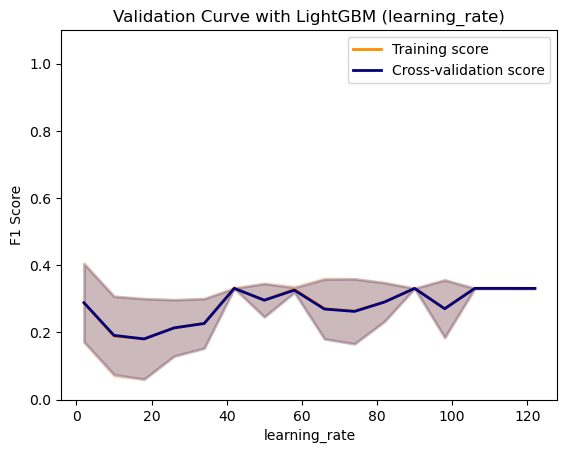

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

# Choose the hyperparameter you want to analyze
hyperparameter = 'learning_rate'

# Define the range of values for the hyperparameter
param_range = np.arange(2, 129, 8)  # Adjust this range as needed

# Get the validation curve
train_scores, test_scores = validation_curve(
    lgb.LGBMClassifier(device='gpu', **fixed_params),
    X_train_processed,
    y_train,
    param_name=hyperparameter,
    param_range=param_range,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title(f"Validation Curve with LightGBM ({hyperparameter})")
plt.xlabel(hyperparameter)
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [ ]:
best_params = {'learning_rate': 0.09148661377934526, 'n_estimators': 819, 'max_depth': 3, 'num_leaves': 92, 'min_data_in_leaf': 32, 'feature_fraction': 0.9878041253717492, 'subsample': 0.4067385074752453, 'lambda_l1': 0.8104733347910597, 'lambda_l2': 2.1242532204737058e-07, 'min_gain_to_split': 0.8408350719709347}

In [ ]:
import shap
from lightgbm import LGBMClassifier

#class_weight = {0:1, 1:40}

model = LGBMClassifier(device='gpu',class_weight = class_weights_dict, **best_params)

model.fit(X_train_processed, y_train)

y_pred_proba = model.predict_proba(X_test_processed)

## calculate best threshold & best gain

In [ ]:
def calculate_gain(cm, fp=-3000, tp=117000):
    return (cm[0][1] *fp + cm[0][2]*fp + cm[1][2] * fp + (cm[2][2]*tp)+(cm[1][1]*tp))

def find_best_thresholds(y_test, y_pred_proba, step=0.1):
    max_gain = float('-inf')
    best_thresholds = None

    threshold_range = np.arange(0.001, 1 + step, step)
    for thresholds in itertools.product(threshold_range, repeat=3):
        y_pred_adjusted_proba = adjust_proba(y_pred_proba, thresholds)
        y_pred_adjusted = np.argmax(y_pred_adjusted_proba, axis=1)
        cm = confusion_matrix(y_test, y_pred_adjusted)
        gain = calculate_gain(cm)

        if gain > max_gain:
            max_gain = gain
            best_thresholds = thresholds

    return best_thresholds, max_gain

def adjust_proba(proba, thresholds):
    adjusted_proba = np.zeros_like(proba)
    for i in range(proba.shape[1]):
        adjusted_proba[:, i] = proba[:, i] / thresholds[i]
    return adjusted_proba

In [ ]:
def calculate_optimal_threshold(model, X_test, y_test, step=0.1, fp=-3000, tp=117000):    

    y_pred_proba = model.predict_proba(X_test)
    best_thresholds, max_gain = find_best_thresholds(y_test, y_pred_proba, step)

    # Apply the custom threshold function
    y_pred_adjusted_proba = adjust_proba(y_pred_proba, best_thresholds)
    y_pred_adjusted = np.argmax(y_pred_adjusted_proba, axis=1)

    print("Best thresholds:", best_thresholds)
    print("Max gain:", max_gain)    

    report = classification_report(y_test, y_pred_adjusted)
    print("Classification report:\n", report)

    cm = confusion_matrix(y_test, y_pred_adjusted)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    plt.show()
    
    
    # Calculate SHAP values using TreeExplainer
    explainer = shap.TreeExplainer(model)
    X_sample = X_test.sample(1000)
    shap_values = explainer.shap_values(X_sample)   
    positive_class_shap_values = shap_values[1]
    shap.summary_plot(positive_class_shap_values, X_sample, feature_names=X_sample.columns)

    return best_thresholds, y_pred_adjusted

In [ ]:
best_thresholds, y_pred_adjusted = calculate_optimal_threshold(model, X_train_processed, y_train)

In [ ]:
best_thresholds, y_pred_adjusted = calculate_optimal_threshold(model, X_test_processed, y_test)

In [ ]:
y_pred = model.predict(X_train_processed)

In [ ]:
#y_pred = model.predict(X_test_processed)

cm = confusion_matrix(y_train, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

# predict and submit

In [ ]:
dapply = preproc_func(dapply,palabras_agrupar)

In [ ]:
dapply = create_good_ratios(dapply, best_unb)

In [ ]:
y_pred_result = model.predict_proba(preprocessing.transform(dapply))

y_pred_adjusted_proba = adjust_proba(y_pred_result, best_thresholds)
y_pred_adjusted = np.argmax(y_pred_adjusted_proba, axis=1)

# Create a DataFrame for predicted labels using the same index as numero_de_cliente
predicted_df = pd.DataFrame(y_pred_adjusted, columns=['Predicted'], index=dapply.index)

# Combine the numero_de_cliente and predicted labels
end_result = pd.concat([dapply['numero_de_cliente'], predicted_df], axis=1)

In [ ]:
end_result['Predicted'].value_counts()

In [ ]:
#end_result['Predicted'].replace({1:0}, inplace=True)
end_result['Predicted'].replace({2:1}, inplace=True)
end_result['Predicted'].value_counts()

In [ ]:
#using 0.25 thresh

y_pred_result = model.predict_proba(preprocessing.transform(dapply))
predicted_df = pd.DataFrame((y_pred_result[:,1]>= 0.025).astype(int), columns=['Predicted'], index=dapply.index)
# Combine the numero_de_cliente and predicted labels
end_result = pd.concat([dapply['numero_de_cliente'], predicted_df], axis=1)

In [ ]:
end_result.to_csv("K101_001.csv", index=False)

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'lechuck666'
os.environ['KAGGLE_KEY'] = '3aaf0a00c8b35504b64d43d4592d6caf'
!kaggle competitions submit -c laboratorio-de-imp-i-2023-virtual -f ./K101_001.csv -m "2nd_less var"